In [1]:
cfg={
    'main_folder':'/home/kvassay/data/sketch-testing/',
    'dataset_file':'dataset.npy',
    'dist_estimation_ref_obj_count': 100,
    'dist_estimation_p_vals':[1,2],
    'evaluation_set_query_obj_cnt':100,
    'evaluation_set_result_set_size':100
}

In [2]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from scipy.spatial.distance import minkowski, hamming
from time import time

In [3]:
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [4]:
def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f)

class IterationLogger(object):
    def __init__(self, message='Started iteration no.: %s\n Time from previous iteration: %ss\n Time from start: %ss',log_by=1000):
        self.log_by=log_by
        self.num_iter=0
        self.msg=message
        self.time_started=None
        self.time_this_iter=None
        
    def next_iter(self):
        if self.time_this_iter is None:
            self.time_this_iter=time()
        if self.time_started is None:
            self.time_started=time()
        self.num_iter+=1
        if self.num_iter%self.log_by==0:
            dur_from_previous=time()-self.time_this_iter
            self.time_this_iter=time()
            dur_from_start=time()-self.time_started
            log_pfx(self, self.msg, str(self.num_iter), str(dur_from_previous), str(dur_from_start))
            

### LOAD DATA

In [5]:
dataset_path=cfg['main_folder']+cfg['dataset_file']

In [6]:
with open(dataset_path, 'rb') as f:
    decaf_vecs=np.load(f)
obj_ids=np.arange(len(decaf_vecs))

In [7]:
decaf_vecs.shape #(vectors count, vector length)

(86648, 4096)

### DATA ANALYSIS


#### Distance distribution estimation

In [8]:
def estimate_minkowski_dist_distr(vec_matrix, ref_obj_cnt, p):
    '''
    p can be either single value or list of p parameters for minkowski distance
    '''
    distances=[list() for _ in range(len(p))]
    reference_objs=vec_matrix[np.random.choice(vec_matrix.shape[0], size=ref_obj_cnt, replace=False)] #sampling without replacement
    iter_log=IterationLogger(log_by=5000)
    for decaf_vec in decaf_vecs:
        iter_log.next_iter()
        for ref_obj in reference_objs:
            for i, val_p in enumerate(p):
                dist=minkowski(ref_obj, decaf_vec, p=val_p)
                distances[i].append(dist)
    return tuple(distances)

In [9]:
dist_l1, dist_l2 = estimate_minkowski_dist_distr(decaf_vecs,  cfg['dist_estimation_ref_obj_count'], cfg['dist_estimation_p_vals'])

2017-04-11 16:45:02,253 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 24.5637040138s
 Time from start: 24.5637040138s
2017-04-11 16:45:26,201 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 23.9483771324s
 Time from start: 48.5120811462s
2017-04-11 16:45:50,817 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 24.6159949303s
 Time from start: 73.1280760765s
2017-04-11 16:46:14,859 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 24.0418419838s
 Time from start: 97.169919014s
2017-04-11 16:46:38,810 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 23.9508581161s
 Time from start: 121.120778084s
2017-04-11 16:47:05,267 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 26.4566578865s
 Time from start: 147.577437162s
2017-04-11 1

In [10]:
dist_l1_ser=pd.Series(dist_l1)
dist_l2_ser=pd.Series(dist_l2)

In [11]:
dist_l1_ser.describe()

count    8.664800e+06
mean     2.647457e+03
std      3.241166e+02
min      0.000000e+00
25%      2.440370e+03
50%      2.647141e+03
75%      2.853509e+03
max      5.098166e+03
dtype: float64

In [12]:
dist_l2_ser.describe()

count    8.664800e+06
mean     8.394643e+01
std      1.155470e+01
min      0.000000e+00
25%      7.615974e+01
50%      8.291862e+01
75%      9.034240e+01
max      1.856646e+02
dtype: float64

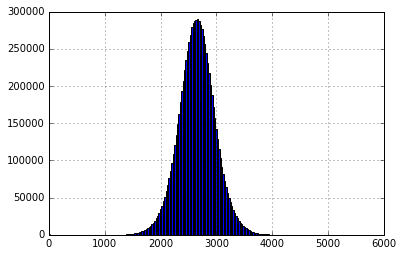

In [13]:
dist_l1_ser.hist(bins=200)

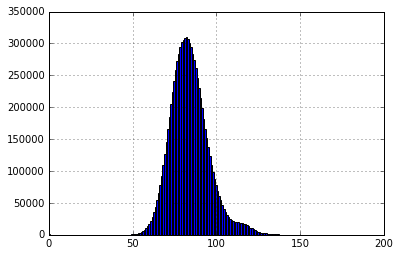

In [14]:
dist_l2_ser.hist(bins=200)

## APPROXIMATION  EVALUATION SET
We select 100 query objects and their 100 closest object's id's from the dataset to evaluate. It simulates the scenario where almost never more than 100 objects are required for result set. 

In [15]:
eval_queries_indicies=np.random.choice(decaf_vecs.shape[0], size=cfg['evaluation_set_query_obj_cnt'], replace=False)
eval_queries_vecs=decaf_vecs[eval_queries_indicies] 
eval_queries_ids=obj_ids[eval_queries_indicies]
eval_k=cfg['evaluation_set_result_set_size'] #k for knn to evaluation objects

In [16]:
eval_result_objs=[list() for _ in range(len(eval_queries_ids))]

Finds k-NN query result

In [17]:
iter_log=IterationLogger(log_by=5000)
for i in range(len(decaf_vecs)):
    iter_log.next_iter()
    candidate_vec=decaf_vecs[i]
    candidate_id=obj_ids[i]
    for j in range(len(eval_queries_vecs)):
        query_vec=eval_queries_vecs[j]
        dist=minkowski(candidate_vec, query_vec, p=1)
        if len(eval_result_objs[j])>0:
            if dist<eval_result_objs[j][-1][1]: #if not object is not member of result set
                eval_result_objs[j].append((candidate_id, dist))
                eval_result_objs[j].sort(key=lambda x: x[1],reverse=False)
                if len(eval_result_objs[j])>eval_k:#if > k objects remove last one
                    del eval_result_objs[j][-1] 
        else:
            eval_result_objs[j].append((candidate_id, dist))
            

2017-04-11 16:52:09,063 - root - INFO - IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 13.8127498627s
 Time from start: 13.8127501011s
2017-04-11 16:52:21,747 - root - INFO - IterationLogger| Started iteration no.: 10000
 Time from previous iteration: 12.6839048862s
 Time from start: 26.496655941s
2017-04-11 16:52:33,932 - root - INFO - IterationLogger| Started iteration no.: 15000
 Time from previous iteration: 12.1844050884s
 Time from start: 38.6810619831s
2017-04-11 16:52:47,046 - root - INFO - IterationLogger| Started iteration no.: 20000
 Time from previous iteration: 13.1145539284s
 Time from start: 51.7956180573s
2017-04-11 16:52:59,839 - root - INFO - IterationLogger| Started iteration no.: 25000
 Time from previous iteration: 12.7923789024s
 Time from start: 64.5879969597s
2017-04-11 16:53:12,458 - root - INFO - IterationLogger| Started iteration no.: 30000
 Time from previous iteration: 12.6198010445s
 Time from start: 77.2078030109s
2017-04-11 1

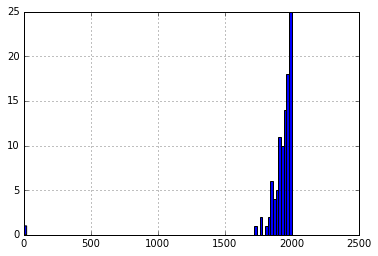

In [28]:
pd.Series([obj[1] for obj in eval_result_objs[17]]).hist(bins=100)